# 4. h5 -> seperate particles -> cleaning -> png images !
This is updated code for reading in 2D-S / HVPS h5 files, extracting the particles, cleaning the images (only significant particles present) and save individual particles as png.

this is the streamlined code from previous + also using Jaffeux 

with optional stats about particles also created

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from glob import glob
import seaborn as sns
import xesmf as xe
import pandas as pd
#import def_homebrew as hb ## homemade functions xox
from scipy.special import gamma
import netCDF4 as nc
from datetime import datetime, timedelta

import h5py ####
from PIL import Image
import os

from scipy.ndimage import convolve, label
from skimage.measure import regionprops, find_contours
from scipy.spatial import ConvexHull, distance_matrix
from skimage.morphology import remove_small_holes ## remove holes <3
from scipy.ndimage import binary_fill_holes
from skimage import measure
import tensorflow as tf

### some new ones
from matplotlib.patches import Ellipse
from scipy.spatial.distance import pdist, squareform, euclidean
import skimage
from skimage import io
from skimage.measure import perimeter
from skimage.morphology import binary_dilation
from skimage.morphology import skeletonize, thin
from skimage.graph import route_through_array

2024-11-20 23:29:31.232285: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#!which python
print(skimage.__version__)


0.24.0


In [ ]:
## path to raw h5 

# 2ds !! be careful of channels
path_h5_ds_0 = '/gws/nopw/j04/dcmex/users/ezriab/raw_h5/2ds/ch_0/'
path_h5_ds_1 = '/gws/nopw/j04/dcmex/users/ezriab/raw_h5/2ds/ch_1/'

# hvps
path_h5_hvps = '/gws/nopw/j04/dcmex/users/ezriab/raw_h5/hvps/'

base_save_path = '/gws/nopw/j04/dcmex/users/ezriab/'

'''
## some practice files - don't want to interfear actual data
path_h5_ds_0 = '/home/users/esree/data/'
path_h5_hvps = '/home/users/esree/data/'

#file_name = 'ch_0_ds_Export_base220719154358.h5'
#file_name = 'hvps_Export_base220716161816.h5'
#file_name = 'Export_base220730153000.h5'

#Export_base220730153000.h5
'''

path = path_h5_ds_0 ######################################################

if os.path.exists(path):
    # get string of full path + filenames in specif location
    file_list = glob(path+'Export_base*.h5') 
    
    # just get file names
    file_names = [os.path.basename(file_path) for file_path in file_list]
else:
    print("NOT REAL OH NO")

### save path - will changing for processing images

In [ ]:
## adding automation - makes sure to change when processing images !!!!!!!!!!!!!
if '2ds' in file_list[0]:
    if 'ch_0' in file_list[0]:
        save_path = base_save_path+'processed_stats/ch_0/'

    elif 'ch_1' in file_list[0]:
        save_path = base_save_path+'processed_stats/ch_1/'

elif 'hvps' in file_list[0]:
    save_path = base_save_path+'processed_stats/hvps/'

In [3]:
file_name = 'Export_base220730153000.h5'
#save_path = '/gws/nopw/j04/dcmex/users/ezriab/processed_images/2ds/ch_0/'
save_path = '/home/users/esree/'
particle_type = 'ch_0'

In [4]:
print(file_name[11:23])
print(file_name[-15:-3])

220730153000
220730153000


## je m'appelle open

In [5]:
# code written to run on 1 h5 file at a time
#file_path_name = path_h5_ds_0+file_name
#file_path_name = path_h5_hvps+example_hvps

file_path_name = save_path+file_name
## open
h5_file = h5py.File(file_path_name,'r')

In [6]:
h5_image = h5_file['ImageData']
h5_time = h5_file['ImageTimes']

##### make xarray of useful time data #####
sec_since = h5_time[:,0]
pixel_slice = h5_time[:,1]
pix_sum = pixel_slice.cumsum(dtype = 'int')

## make useful datetime format (not seconds since midnight)
# using the file name for reference
date_str = file_name[-15:-9]
long_date_string = file_name[-15:-3]
starting_date = datetime.strptime(date_str, '%y%m%d')
time_deltas = [timedelta(seconds=float(sec)) for sec in sec_since]
utc_time = [starting_date + delta for delta in time_deltas]

time_xr =xr.Dataset({
    'utc_time':utc_time,
    'pixel_slice': pixel_slice,
    'pix_sum': pix_sum})

## start and end time of data
print(time_xr['utc_time'][0])
print(time_xr['utc_time'][-1])

<xarray.DataArray 'utc_time' ()> Size: 8B
array('2022-07-30T16:44:00.369000000', dtype='datetime64[ns]')
Coordinates:
    utc_time  datetime64[ns] 8B 2022-07-30T16:44:00.369000
<xarray.DataArray 'utc_time' ()> Size: 8B
array('2022-07-29T23:59:59.000000000', dtype='datetime64[ns]')
Coordinates:
    utc_time  datetime64[ns] 8B 2022-07-29T23:59:59


## functions

In [7]:
## functions to make code run smoothly
def stats_description(bw_crystal, fill_hole_thresh):
    #take binary image, fill in small holes and returns object containing stats about crystal
    
    filled_particle = remove_small_holes(bw_crystal.image, area_threshold=fill_hole_thresh) # fill in voids within binary image - better estimation of stats # may need to be altered
    
    # can see the filled in particle if needs be
    #plt.imshow(filled_particle, cmap='gray')
    
    if filled_particle.shape[0] < 2 or filled_particle.shape[1] < 2:
        return filled_particle, None
        
    contours = measure.find_contours(filled_particle, 0.5)
    if contours:
        contour = max(contours, key=lambda x: x.shape[0])  # Sort contours by area (largest first) and select the largest contour
        
        labeled_image = measure.label(filled_particle)  # Label the image based on the threshold
        region = measure.regionprops(labeled_image)[0]  # Assumes largest labeled region corresponds to largest contour
        
        return filled_particle, region
    else:
        return filled_particle, None
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
'''
## function to calculate truncation of particle
def calc_truncation(a_slice, particle):
    # the intial slice is the raw 2ds data - of whole array, and particle is one selected by regionprops (and has to be 1s + 0s)
    ## assume slices are small + don't contain too many odd bits
    # first convert to 0 and 1 for calculation of truncation
    alt_crystal = np.where(a_slice == 255, 0, 1) # i.e. 255 (blank area)=0, and where crystal is (was 0) = 1
    # so sum up number of particle pixels are on the edge of the slice
    first_diode = sum(alt_crystal[0,:]) 
    last_diode = sum(alt_crystal[-1,:])

    ## this calculates how many pixels are top / bottom of the particle + then infer number pixels touching
    top_particle = np.sum(particle[0] == 1)
    bottom_particle = np.sum(particle[-1] == 1)

    n_top, n_bottom = 0, 0  # Initialize variables, default 0 when conditions are not met

    # Top pixel touching logic
    if first_diode != 0 and first_diode >= top_particle:
        n_top = top_particle
    elif first_diode == 0:
        n_top = 0

    # Bottom pixel touching logic
    if last_diode != 0 and last_diode >= bottom_particle:
        n_bottom = bottom_particle
    elif last_diode == 0:
        n_bottom = 0

    return n_top, n_bottom # number pixels touching top / bottom respectively
'''

## function to calculate truncation of particle
def calc_truncation(particle_coords):
    ## so much simpler, looking at list of coordinates making up a particle, then summing ones in 0 and 127 row - i.e. first + last diode
    lst_first_diode = [coord for coord in particle_coords if coord[0] == 0]
    lst_last_diode = [coord for coord in particle_coords if coord[0] == 127]

    n_top = len(lst_first_diode)
    n_bottom = len(lst_last_diode)

    #also worth looking if left -> right is larger than 200 pixels (will be truncated in final image)

    return n_top, n_bottom # number pixels touching top / bottom respectively


## couple different diameters     

## basic cleaning
mask the slices that are < 4 pixels in length (remove lot of tiny particles)

In [8]:
## cleaning of whole h5 file 
## this has been edited - allow for corresponding time
pix_sum = time_xr['pix_sum']
utc_time = time_xr['utc_time']

# Calculate the difference
diff = np.diff(pix_sum.values)

# Create a mask where the difference is greater than 4 - i.e. select segments of significant sizze
mask = diff > 4
# Apply the mask to select the corresponding values from pix_sum and utc_time
selected_pix_sum = pix_sum[:-1][mask]
selected_utc_time = utc_time[:-1][mask]

## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [9]:
## setting thresholds / res for attaining good particle final images
fill_hole_threshold = 5 # max number pixels contained within particle that is filled in

minimum_area = 15 # very quick metric to stop the processing of particles with area < 15 pixels

length_threshold = 100 #300 # mu - need this minimum length of max dimension to extract the particle
pixel_resolution = 10 # mu
desired_image_size = 200 # (assume we want a square image) 200 x 200

In [10]:
###  set up dataframe, used to extract from raw h5 file + has stats about the particle
columns = [
    "name",
    "date",
    "slice_s_idx",
    "slice_e_idx",
    "start_time",
    "end_time",
    "d_max",
    "d_min",
    "orientation",
    "centroid",
    "area",
    "perimeter",
    "circularity",
    "y0",
    "y1",
    "probe",
    "first_diode_trunc",
    "last_diode_trunc"
    ]
particle_df = pd.DataFrame(columns=columns)

In [19]:
num = 3578
save_image = False

# loop though length of images that are somewhat usable
#start_idx = 1005300
#end_idx = 1005500
## example numbers
# nice examples: 32, 2344, 3452, 2350
# truncated: 1059, 2345
# too small (for threshold - but recognisable): 1345. 

Dmax (Major Axis): 13.43, Euclidean: 13.00, Feret: 13.93
Orientation: 55.93°, Aspect Ratio: 1.31


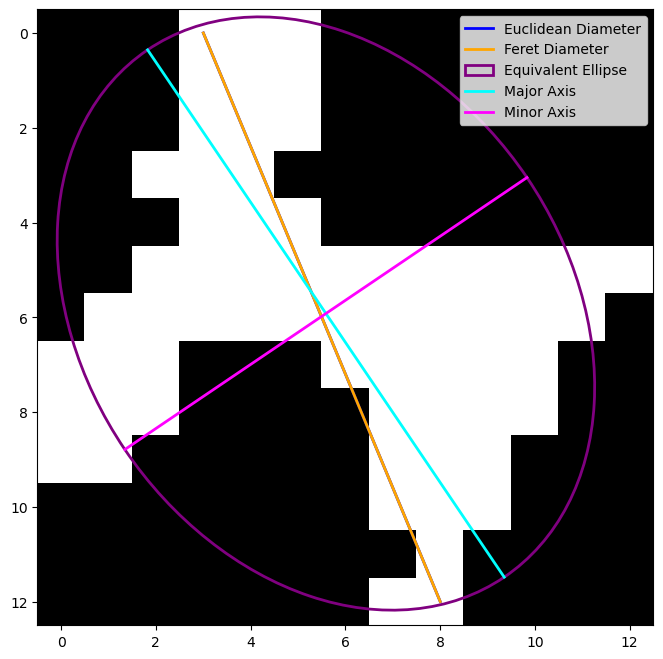

Circularity: 2.29


In [20]:
# Loop through the selected regions of interest (crystals)
for i in range(num, num + 1):  # Example loop for single region (adjust range as needed)

    # Extract one crystal region
    one_crystal = h5_file['ImageData'][:, int(selected_pix_sum[i]):int(selected_pix_sum[i + 1])]
    binary_image = (one_crystal == 0)  # Convert regions where 0=True (bits of interest)

    # Label connected regions
    labeled_image, num_features = label(binary_image)
    props = regionprops(labeled_image)  # Analyze properties of detected features

    if props:
        for particle in props:
            # Filter particles based on minimum area
            if particle.area >= minimum_area:
                filled_part, spec_region = stats_description(particle, fill_hole_threshold)

                # Filter based on major axis length and other thresholds
                if spec_region and spec_region.major_axis_length * pixel_resolution >= length_threshold \
                        and spec_region.minor_axis_length > 4:
                    
                    # Extract coordinates of the particle
                    coords = particle.coords  # Coordinates of each point of interest
                    other_coords = spec_region.coords
                    x_values = np.unique(coords[:, 1])  # Unique column values
                    s_idx = int(selected_pix_sum[i] + x_values[0])
                    e_idx = int(selected_pix_sum[i] + x_values[-1])

                    # 1. Convex Hull for Feret Diameter
                    hull = ConvexHull(other_coords)
                    hull_points = other_coords[hull.vertices]  # Points on the convex hull
                    
                    # Compute pairwise distances on the convex hull for Feret diameter
                    hull_distances = pdist(hull_points)
                    feret_diameter_max = np.max(hull_distances)
                    
                    # Find the points corresponding to the maximum Feret diameter
                    hull_dist_matrix = squareform(hull_distances)
                    feret_point1_idx, feret_point2_idx = np.unravel_index(np.argmax(hull_dist_matrix), hull_dist_matrix.shape)
                    feret_point1, feret_point2 = hull_points[feret_point1_idx], hull_points[feret_point2_idx]
                    
                    # 2. Euclidean Diameter
                    distances = pdist(other_coords)
                    euclidean_dim = np.max(distances)
                    
                    # Find points corresponding to the maximum Euclidean diameter
                    dist_matrix = squareform(distances)
                    point1_idx, point2_idx = np.unravel_index(np.argmax(dist_matrix), dist_matrix.shape)
                    point1, point2 = other_coords[point1_idx], other_coords[point2_idx]
                    
                    # Aspect ratio (major/minor axes)
                    aspect_ratio_value = spec_region.major_axis_length / spec_region.minor_axis_length

                    # Display calculated values
                    orientation_deg = np.degrees(spec_region.orientation)
                    print(f"Dmax (Major Axis): {spec_region.major_axis_length:.2f}, "
                          f"Euclidean: {euclidean_dim:.2f}, "
                          f"Feret: {spec_region.feret_diameter_max:.2f}")
                    print(f"Orientation: {orientation_deg:.2f}°, Aspect Ratio: {aspect_ratio_value:.2f}")

                    # # ~~~~~~~~~~~~~~~~~~~~~~~~~~~ Visualization ~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

                    # Extract ellipse parameters
                    centroid = spec_region.centroid  # (row, col)
                    major_axis = spec_region.major_axis_length
                    minor_axis = spec_region.minor_axis_length
                    orientation_deg = np.degrees(spec_region.orientation)

                    fig, ax = plt.subplots(figsize=(8, 8))
                    ax.imshow(filled_part, cmap='gray', label='Particle')
                    #ax.imshow(binary_image, cmap='gray', label='Particle')
                    
                    # Plot boundaries and key measurements
                    #ax.scatter(coords[:, 1], coords[:, 0], s=1, c='red', label='Boundary Points')
                    ax.plot([point1[1], point2[1]], [point1[0], point2[0]], 'b-', linewidth=2, label='Euclidean Diameter')
                    ax.plot([feret_point1[1], feret_point2[1]], [feret_point1[0], feret_point2[0]], 'orange', linewidth=2,
                            label='Feret Diameter')

                    
                    # Add equivalent ellipse
                    ellipse = Ellipse(
                        xy=(centroid[1], centroid[0]),  # Ellipse center (x, y)
                        width=major_axis,
                        height=minor_axis,
                        angle=orientation_deg,
                        edgecolor='purple',
                        facecolor='none',
                        linewidth=2,
                        label='Equivalent Ellipse'
                    )
                    ax.add_patch(ellipse)
                    
                    # Plot major and minor axes
                    major_end1 = (
                        centroid[0] + 0.5 * major_axis * np.sin(spec_region.orientation),
                        centroid[1] + 0.5 * major_axis * np.cos(spec_region.orientation)
                    )
                    major_end2 = (
                        centroid[0] - 0.5 * major_axis * np.sin(spec_region.orientation),
                        centroid[1] - 0.5 * major_axis * np.cos(spec_region.orientation)
                    )
                    ax.plot(
                        [major_end1[1], major_end2[1]],
                        [major_end1[0], major_end2[0]],
                        'cyan', linewidth=2, label='Major Axis'
                    )
                    
                    minor_end1 = (
                        centroid[0] + 0.5 * minor_axis * np.cos(spec_region.orientation),
                        centroid[1] - 0.5 * minor_axis * np.sin(spec_region.orientation)
                    )
                    minor_end2 = (
                        centroid[0] - 0.5 * minor_axis * np.cos(spec_region.orientation),
                        centroid[1] + 0.5 * minor_axis * np.sin(spec_region.orientation)
                    )
                    ax.plot(
                        [minor_end1[1], minor_end2[1]],
                        [minor_end1[0], minor_end2[0]],
                        'magenta', linewidth=2, label='Minor Axis'
                    )
                    
                    # Finalize and save the plot
                    ax.legend(loc='upper right')
                    if save_image:
                        plt.savefig('/home/users/esree/2DS_code/lol_images/annotated_image.png', bbox_inches='tight')
                    plt.show()

                    # Truncation and circularity calculations
                    first_diode, last_diode = calc_truncation(coords)
                    circularity = (spec_region.perimeter ** 2) / (4 * np.pi * spec_region.area)
                    print(f"Circularity: {circularity:.2f}")


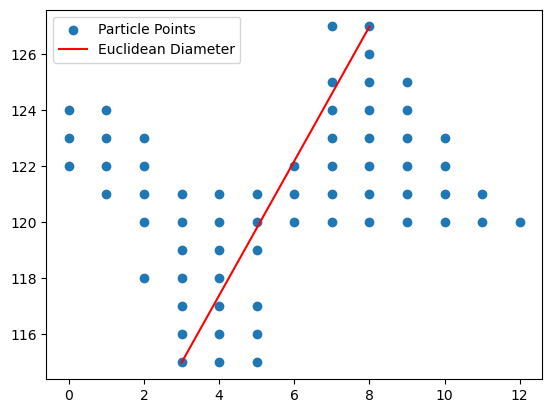

In [21]:
# Compute pairwise distances
distances = pdist(coords)
euclidean_dim = np.max(distances)

# Find the two points corresponding to the maximum distance
distance_matrix = squareform(distances)
i, j = np.unravel_index(np.argmax(distance_matrix), distance_matrix.shape)

# Plot the particle and the Euclidean diameter
plt.scatter(coords[:, 1], coords[:, 0], label="Particle Points")
plt.plot([coords[i, 1], coords[j, 1]], [coords[i, 0], coords[j, 0]], 'r-', label="Euclidean Diameter")
plt.legend()
plt.show()

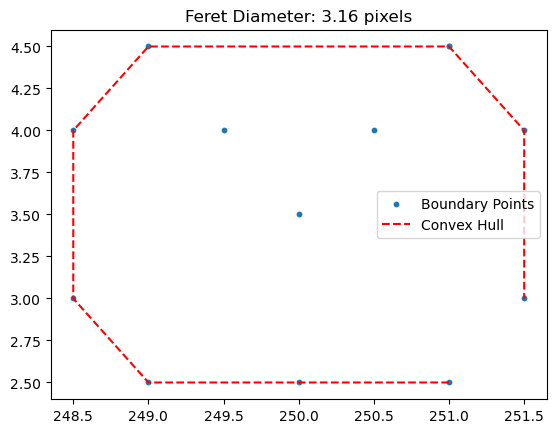

In [15]:
# Assuming 'binary_image' is a binary mask of the object
contours = find_contours(binary_image, level=0.5)[0]  # Extracts boundary points

hull = ConvexHull(contours)
hull_points = contours[hull.vertices]  # Coordinates of the convex hull

def feret_diameter(points):
    angles = np.linspace(0, np.pi, 180)  # Test angles from 0 to 180 degrees
    max_distance = 0

    for angle in angles:
        # Rotation matrix
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                     [np.sin(angle), np.cos(angle)]])
        # Rotate points
        rotated_points = np.dot(points, rotation_matrix.T)
        
        # Project points onto the x-axis
        min_x, max_x = np.min(rotated_points[:, 0]), np.max(rotated_points[:, 0])
        
        # Distance between the two furthest points
        distance = max_x - min_x
        max_distance = max(max_distance, distance)

    return max_distance

# Calculate Feret diameter
feret_d_max = feret_diameter(hull_points)

# Example visualization
fig, ax = plt.subplots()
ax.scatter(contours[:, 1], contours[:, 0], s=10, label="Boundary Points")
ax.plot(hull_points[:, 1], hull_points[:, 0], 'r--', label="Convex Hull")
ax.set_title(f"Feret Diameter: {feret_d_max:.2f} pixels")
ax.legend()
plt.show()

#### which Euclidean Diameter ???? aghhh

In [66]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~  #
# loop though length of images that are somewhat usable
#start_idx = 1005300
#end_idx = 1005500
## example numbers
# nice examples: 32, 2344, 3452, 2350
# truncated: 1059, 2345
# too small (for threshold - but recognisable): 1345. 
'''
## also writing to a txt doc about the processing of these images
if not os.path.exists(save_path+f'flight_{file_name[11:23]}'):
    os.makedirs(save_path+f'flight_{file_name[11:23]}')
save_loc = save_path+f'flight_{file_name[11:23]}'+'/'

with open(f'{full_save_path}running_{long_date_string}.txt', "w") as file:
'''    
for i in range(num,num+1):
#for i in range(len(selected_pix_sum)-2):

    # pull out selected area + do analysis
    one_crystal = h5_file['ImageData'][:,int(selected_pix_sum[i]):int(selected_pix_sum[i+1])] # extract 1 crystal
    #one_crystal = h5_file['ImageData'][:,start_idx:end_idx] # extract 1 crystal
    
    
    #plt.imshow(one_crystal, cmap='gray')
    #plt.axis('off') # Turn off axis labels
    #plt.show()
    if save_image == True:
        plt.imsave('/home/users/esree/2DS_code/lol_images/one_slice.png', one_crystal, cmap="gray")
    
    binary_image = (one_crystal == 0) ## important, convert regions where 0 = True (our bits of interest), all else false
    
    labeled_image, num_features = label(binary_image) # identify connected true areas
    # labeled_image = array, with each true area given a number to identify them
    # num_features = number of unique connected components in image. Have to literally have adjacent pixel, not diagonal (this will make them seperate)
    
    #plt.imshow(labeled_image)
    #plt.axis('off') # Turn off axis labels
    #plt.show()
    if save_image == True:
        plt.imsave('/home/users/esree/2DS_code/lol_images/one_slice_labelled.png', labeled_image)
   
    
    props = regionprops(labeled_image) # creates quick list of properties describing each feature detected in the image.
    ## (features are measured in ~ pixels)
    
    if props:
        for particle in props: # go through each particle detected
            # quickly get rid of tiny particles
            if particle.area >= minimum_area:
                ## more complex stats
                filled_part, spec_region = stats_description(particle,fill_hole_threshold)

                
                ### quite important, this is remove unwanted particles
                # putting in some conditions to take measurements: d_max needs to be min size, and so does d_min - 4 pixels (remove streak particles)
                if spec_region and spec_region.major_axis_length * pixel_resolution >= length_threshold and spec_region.minor_axis_length > 4:

                    # Extract coordinates of the particle
                    coords = particle.coords  # Coordinates of each point of interest
                    
                    
                    x_values = np.unique(coords[:, 1])  # Unique column values
                    s_idx = int(selected_pix_sum[i] + x_values[0])
                    e_idx = int(selected_pix_sum[i] + x_values[-1])
                    
                    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~ New Diameter Calculations ~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
                    # Extract boundary points
                    boundary = filled_part ^ binary_dilation(filled_part)
                    boundary_coords = np.argwhere(boundary)
                    
                    # Compute minimum diameter
                    min_diameter = np.min(pdist(boundary_coords))
                    
                    # Compute maximum Euclidean distance (longest straight-line diameter)
                    distances_1 = pdist(boundary_coords)
                    euclidean_dim_1 = np.max(distances_1)
                        ## ^^ Computes the maximum distance between any two points on the boundary of the filled particle.
                        ###   This measures the longest straight-line distance along the particle's edge, effectively representing the Feret diameter if boundary points are adequately sampled
                        ###   similar to Feret Diameter

                      # 2. Euclidean Diameter
                    distances_2 = pdist(coords)
                    euclidean_dim_2 = np.max(distances_2)
                        ## ^^ Computes the maximum distance between any two points inside the particle, including its boundary.
                        ####  This measures the overall longest straight-line distance within the particle and may better capture the particle's physical "extent" across its entirety.
                        ####   longest straight-line distance within the entire filled particle

                    print(f'euclidean_dim_1: {euclidean_dim_1:.2f}, euclidean_dim_2: {euclidean_dim_2:.2f}, Feret: {spec_region.feret_diameter_max:.2f}')
                    
                                    

euclidean_dim_1: 56.36, euclidean_dim_2: 54.59, Feret: 55.47


Old Dmin: 8.08, New Dmin: 1.00
Dmax: Old 21.01, Euclidean 21.63, Feret 21.54, Continuous 17.02
Orientation: -28.93°


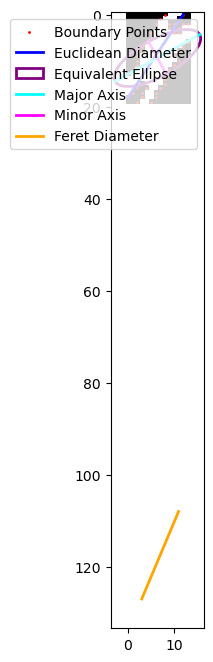

aspect ratio: 2.6006734218444567


In [47]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~  #
# loop though length of images that are somewhat usable
#start_idx = 1005300
#end_idx = 1005500
## example numbers
# nice examples: 32, 2344, 3452, 2350
# truncated: 1059, 2345
# too small (for threshold - but recognisable): 1345. 
'''
## also writing to a txt doc about the processing of these images
if not os.path.exists(save_path+f'flight_{file_name[11:23]}'):
    os.makedirs(save_path+f'flight_{file_name[11:23]}')
save_loc = save_path+f'flight_{file_name[11:23]}'+'/'

with open(f'{full_save_path}running_{long_date_string}.txt', "w") as file:
'''    
for i in range(num,num+1):
#for i in range(len(selected_pix_sum)-2):

    # pull out selected area + do analysis
    one_crystal = h5_file['ImageData'][:,int(selected_pix_sum[i]):int(selected_pix_sum[i+1])] # extract 1 crystal
    #one_crystal = h5_file['ImageData'][:,start_idx:end_idx] # extract 1 crystal
    
    
    #plt.imshow(one_crystal, cmap='gray')
    #plt.axis('off') # Turn off axis labels
    #plt.show()
    if save_image == True:
        plt.imsave('/home/users/esree/2DS_code/lol_images/one_slice.png', one_crystal, cmap="gray")
    
    binary_image = (one_crystal == 0) ## important, convert regions where 0 = True (our bits of interest), all else false
    
    labeled_image, num_features = label(binary_image) # identify connected true areas
    # labeled_image = array, with each true area given a number to identify them
    # num_features = number of unique connected components in image. Have to literally have adjacent pixel, not diagonal (this will make them seperate)
    
    #plt.imshow(labeled_image)
    #plt.axis('off') # Turn off axis labels
    #plt.show()
    if save_image == True:
        plt.imsave('/home/users/esree/2DS_code/lol_images/one_slice_labelled.png', labeled_image)
   
    
    props = regionprops(labeled_image) # creates quick list of properties describing each feature detected in the image.
    ## (features are measured in ~ pixels)
    
    if props:
        for particle in props: # go through each particle detected
            # quickly get rid of tiny particles
            if particle.area >= minimum_area:
                ## more complex stats
                filled_part, spec_region = stats_description(particle,fill_hole_threshold)

                
                ### quite important, this is remove unwanted particles
                # putting in some conditions to take measurements: d_max needs to be min size, and so does d_min - 4 pixels (remove streak particles)
                if spec_region and spec_region.major_axis_length * pixel_resolution >= length_threshold and spec_region.minor_axis_length > 4:

                    # Extract coordinates of the particle
                    coords = particle.coords  # Coordinates of each point of interest
                    
                    x_values = np.unique(coords[:, 1])  # Unique column values
                    s_idx = int(selected_pix_sum[i] + x_values[0])
                    e_idx = int(selected_pix_sum[i] + x_values[-1])
                    
                    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~ New Diameter Calculations ~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
                    # Extract boundary points
                    boundary = filled_part ^ binary_dilation(filled_part)
                    boundary_coords = np.argwhere(boundary)
                    
                    # Compute minimum diameter
                    min_diameter = np.min(pdist(boundary_coords))
                    print(f'Old Dmin: {spec_region.minor_axis_length:.2f}, New Dmin: {min_diameter:.2f}')
                    
                    # Compute maximum Euclidean distance (longest straight-line diameter)
                    distances = pdist(boundary_coords)
                    euclidean_dim = np.max(distances)
                    
                    # Identify the points corresponding to the maximum distance
                    dist_matrix = squareform(distances)
                    point1_idx, point2_idx = np.unravel_index(np.argmax(dist_matrix), dist_matrix.shape)
                    point1, point2 = boundary_coords[point1_idx], boundary_coords[point2_idx]
                    
                    # Compute longest continuous boundary length
                    contours = find_contours(filled_part, level=0.5)[0]  # Ordered boundary points
                    continuous_distances = [0]  # Start cumulative distance from 0
                    for j in range(1, len(contours)):
                        continuous_distances.append(
                            continuous_distances[-1] + euclidean(contours[j - 1], contours[j])
                    )
                    continuous_d = continuous_distances[-1]
                    
                    
                    # Display calculated diameters and orientation
                    orientation_deg = np.degrees(spec_region.orientation)
                    print(f"Dmax: Old {spec_region.major_axis_length:.2f}, Euclidean {euclidean_dim:.2f}, "
                          f"Feret {spec_region.feret_diameter_max:.2f}, Continuous {continuous_d:.2f}")
                    print(f"Orientation: {orientation_deg:.2f}°")

                    
                    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~ Visualization ~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
                    # Extract ellipse parameters
                    centroid = spec_region.centroid  # (row, col)
                    major_axis = spec_region.major_axis_length
                    minor_axis = spec_region.minor_axis_length

                    # Create the plot
                    fig, ax = plt.subplots(figsize=(8, 8))
                    ax.imshow(filled_part, cmap='gray', label='Particle')
                    
                    # Plot boundary points
                    ax.scatter(boundary_coords[:, 1], boundary_coords[:, 0], s=1, c='red', label='Boundary Points')
                    
                    # Plot the longest Euclidean diameter
                    ax.plot([point1[1], point2[1]], [point1[0], point2[0]], 'b-', linewidth=2, label='Euclidean Diameter')
                    
                    # Plot continuous boundary path
                    #ax.plot(contours[:, 1], contours[:, 0], 'green', linewidth=1, label='Boundary Path')
                    
                    # Add the equivalent ellipse
                    ellipse = Ellipse(
                        xy=(centroid[1], centroid[0]),  # Ellipse center (x, y)
                        width=major_axis,              # Major axis
                        height=minor_axis,             # Minor axis
                        angle=orientation_deg,         # Rotation angle in degrees
                        edgecolor='purple',
                        facecolor='none',
                        linewidth=2,
                        label='Equivalent Ellipse'
                    )
                    ax.add_patch(ellipse)
                    
                    # Plot the major and minor axes of the ellipse
                    major_end1 = (
                        centroid[0] + 0.5 * major_axis * np.sin(spec_region.orientation),
                        centroid[1] + 0.5 * major_axis * np.cos(spec_region.orientation)
                    )
                    major_end2 = (
                        centroid[0] - 0.5 * major_axis * np.sin(spec_region.orientation),
                        centroid[1] - 0.5 * major_axis * np.cos(spec_region.orientation)
                    )
                    ax.plot(
                        [major_end1[1], major_end2[1]],
                        [major_end1[0], major_end2[0]],
                        'cyan',
                        linewidth=2,
                        label='Major Axis'
                    )
                    
                    minor_end1 = (
                        centroid[0] + 0.5 * minor_axis * np.cos(spec_region.orientation),
                        centroid[1] - 0.5 * minor_axis * np.sin(spec_region.orientation)
                    )
                    minor_end2 = (
                        centroid[0] - 0.5 * minor_axis * np.cos(spec_region.orientation),
                        centroid[1] + 0.5 * minor_axis * np.sin(spec_region.orientation)
                    )
                    ax.plot(
                        [minor_end1[1], minor_end2[1]],
                        [minor_end1[0], minor_end2[0]],
                        'magenta',
                        linewidth=2,
                        label='Minor Axis'
                    )
                    
                    # Annotate the Feret diameter (if using max Feret diameter points)
                    # Get convex hull of boundary points
                    hull = ConvexHull(coords)
                    hull_points = coords[hull.vertices]  # Points on the convex hull
                    
                    # Compute pairwise distances on convex hull
                    hull_distances = pdist(hull_points)
                    
                    # Find maximum distance on the convex hull (Feret diameter)
                    feret_diameter_max = np.max(hull_distances)
                    
                    # Get the indices of the two points corresponding to the Feret diameter
                    hull_dist_matrix = squareform(hull_distances)
                    feret_point1_idx, feret_point2_idx = np.unravel_index(np.argmax(hull_dist_matrix), hull_dist_matrix.shape)
                    
                    # Extract the actual points
                    feret_point1 = hull_points[feret_point1_idx]
                    feret_point2 = hull_points[feret_point2_idx]
                                        
                    #feret_point1, feret_point2 = point1, point2  # Assuming this represents Feret diameter points
                    
                    ax.plot(
                        [feret_point1[1], feret_point2[1]],
                        [feret_point1[0], feret_point2[0]],
                        'orange',
                        linewidth=2,
                        label='Feret Diameter'
                    )
                    
                    ax.legend(loc='upper right')  # Show legend in the top-right corner

                    if save_image == True:
                        plt.savefig('/home/users/esree/2DS_code/lol_images/annotated_image.png', bbox_inches='tight')
   
                    plt.show()
                    
                    ## aspect ratio calculation - very quick, based on eliptical outline, as true dmin is not helpful
                    aspect_ratio_value = spec_region.major_axis_length / spec_region.minor_axis_length
                    print(f'aspect ratio: {aspect_ratio_value}')

                    """ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ new bits ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ """
                    
                    
                    filled_part = filled_part.astype(np.float32) ## convert to float 0 and 1s
                    filled_part = np.expand_dims(filled_part, axis=-1) ## add extra dimention - this is for adding padding
                    '''
                    imagex = tf.image.resize_with_crop_or_pad(filled_part, desired_image_size, desired_image_size)
                    plt.imshow(imagex, cmap='gray')
                    plt.axis('off') # Turn off axis labels
                    plt.show()
                    if save_image == True:
                        image_np = imagex.numpy().squeeze()
                        plt.imsave('/home/users/esree/2DS_code/lol_images/cnn_crystal.png', image_np, cmap="gray")
                   '''
    
    
                     ## truncation calc
                    first_diode, last_diode = calc_truncation(coords)
                                            
                    ## using circularity calculation from Crosier et al. 2011
                    circularity = np.divide((spec_region.perimeter**2),(4*np.pi*spec_region.area))


Dmax (Major Axis): 21.01, Euclidean: 21.63, Feret: 20.62, Continuous: 17.02
Orientation: -28.93°, Aspect Ratio: 2.60


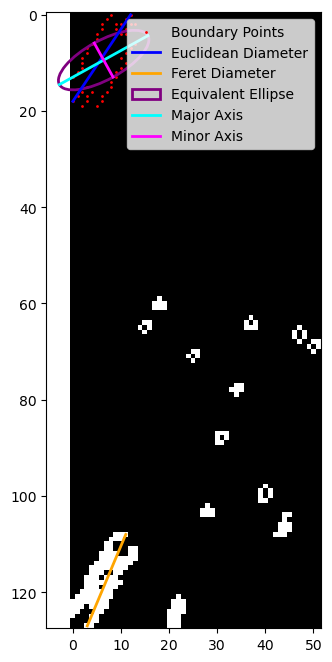

Circularity: 2.65


In [46]:
# Loop through the selected regions of interest (crystals)
for i in range(num, num + 1):  # Example loop for single region (adjust range as needed)

    # Extract one crystal region
    one_crystal = h5_file['ImageData'][:, int(selected_pix_sum[i]):int(selected_pix_sum[i + 1])]
    binary_image = (one_crystal == 0)  # Convert regions where 0=True (bits of interest)

    # Label connected regions
    labeled_image, num_features = label(binary_image)
    props = regionprops(labeled_image)  # Analyze properties of detected features

    if props:
        for particle in props:
            # Filter particles based on minimum area
            if particle.area >= minimum_area:
                filled_part, spec_region = stats_description(particle, fill_hole_threshold)

                # Filter based on major axis length and other thresholds
                if spec_region and spec_region.major_axis_length * pixel_resolution >= length_threshold \
                        and spec_region.minor_axis_length > 4:
                    
                    # Extract coordinates of the particle
                    coords = particle.coords  # Coordinates of each point of interest
                    
                    x_values = np.unique(coords[:, 1])  # Unique column values
                    s_idx = int(selected_pix_sum[i] + x_values[0])
                    e_idx = int(selected_pix_sum[i] + x_values[-1])

                    # Calculate boundary and key properties
                    boundary = filled_part ^ binary_dilation(filled_part)
                    boundary_coords = np.argwhere(boundary)

                    # Minimum diameter
                    min_diameter = np.min(pdist(boundary_coords))
                    
                    # Euclidean diameter (max straight-line distance)
                    distances = pdist(boundary_coords)
                    euclidean_dim = np.max(distances)

                    # Extract endpoints for the Euclidean diameter
                    dist_matrix = squareform(distances)
                    point1_idx, point2_idx = np.unravel_index(np.argmax(dist_matrix), dist_matrix.shape)
                    point1, point2 = boundary_coords[point1_idx], boundary_coords[point2_idx]

                    # Feret diameter (convex hull-based)
                    hull = ConvexHull(particle.coords)
                    hull_points = particle.coords[hull.vertices]
                    hull_distances = pdist(hull_points)
                    feret_diameter_max = np.max(hull_distances)

                    # Extract endpoints for Feret diameter
                    hull_dist_matrix = squareform(hull_distances)
                    feret_point1_idx, feret_point2_idx = np.unravel_index(np.argmax(hull_dist_matrix), hull_dist_matrix.shape)
                    feret_point1, feret_point2 = hull_points[feret_point1_idx], hull_points[feret_point2_idx]

                    # Compute continuous boundary length
                    contours = find_contours(filled_part, level=0.5)[0]
                    continuous_d = sum(euclidean(contours[j], contours[j - 1]) for j in range(1, len(contours)))

                    # Aspect ratio (major/minor axes)
                    aspect_ratio_value = spec_region.major_axis_length / spec_region.minor_axis_length

                    # Display calculated values
                    orientation_deg = np.degrees(spec_region.orientation)
                    print(f"Dmax (Major Axis): {spec_region.major_axis_length:.2f}, "
                          f"Euclidean: {euclidean_dim:.2f}, "
                          f"Feret: {feret_diameter_max:.2f}, Continuous: {continuous_d:.2f}")
                    print(f"Orientation: {orientation_deg:.2f}°, Aspect Ratio: {aspect_ratio_value:.2f}")

                    # Visualization
                    fig, ax = plt.subplots(figsize=(8, 8))
                    #ax.imshow(filled_part, cmap='gray', label='Particle')
                    ax.imshow(binary_image, cmap='gray', label='Particle')
                    
                    # Plot boundaries and key measurements
                    ax.scatter(boundary_coords[:, 1], boundary_coords[:, 0], s=1, c='red', label='Boundary Points')
                    ax.plot([point1[1], point2[1]], [point1[0], point2[0]], 'b-', linewidth=2, label='Euclidean Diameter')
                    ax.plot([feret_point1[1], feret_point2[1]], [feret_point1[0], feret_point2[0]], 'orange', linewidth=2,
                            label='Feret Diameter')

                    # Add equivalent ellipse
                    ellipse = Ellipse(
                        xy=(spec_region.centroid[1], spec_region.centroid[0]),
                        width=spec_region.major_axis_length,
                        height=spec_region.minor_axis_length,
                        angle=orientation_deg,
                        edgecolor='purple',
                        facecolor='none',
                        linewidth=2,
                        label='Equivalent Ellipse'
                    )
                    ax.add_patch(ellipse)

                    # Major and minor axes
                    major_end1 = (
                        spec_region.centroid[0] + 0.5 * spec_region.major_axis_length * np.sin(spec_region.orientation),
                        spec_region.centroid[1] + 0.5 * spec_region.major_axis_length * np.cos(spec_region.orientation)
                    )
                    major_end2 = (
                        spec_region.centroid[0] - 0.5 * spec_region.major_axis_length * np.sin(spec_region.orientation),
                        spec_region.centroid[1] - 0.5 * spec_region.major_axis_length * np.cos(spec_region.orientation)
                    )
                    ax.plot([major_end1[1], major_end2[1]], [major_end1[0], major_end2[0]], 'cyan', linewidth=2, label='Major Axis')

                    minor_end1 = (
                        spec_region.centroid[0] + 0.5 * spec_region.minor_axis_length * np.cos(spec_region.orientation),
                        spec_region.centroid[1] - 0.5 * spec_region.minor_axis_length * np.sin(spec_region.orientation)
                    )
                    minor_end2 = (
                        spec_region.centroid[0] - 0.5 * spec_region.minor_axis_length * np.cos(spec_region.orientation),
                        spec_region.centroid[1] + 0.5 * spec_region.minor_axis_length * np.sin(spec_region.orientation)
                    )
                    ax.plot([minor_end1[1], minor_end2[1]], [minor_end1[0], minor_end2[0]], 'magenta', linewidth=2, label='Minor Axis')

                    # Save or show the image
                    ax.legend(loc='upper right')
                    if save_image:
                        plt.savefig('/home/users/esree/2DS_code/lol_images/annotated_image.png', bbox_inches='tight')
                    plt.show()

                    # Optional: Resize and save for CNN compatibility
                    filled_part = np.expand_dims(filled_part.astype(np.float32), axis=-1)
                    imagex = tf.image.resize_with_crop_or_pad(filled_part, desired_image_size, desired_image_size)
                    if save_image:
                        plt.imsave('/home/users/esree/2DS_code/lol_images/cnn_crystal.png', imagex.numpy().squeeze(), cmap="gray")

                    # Truncation and circularity calculations
                    first_diode, last_diode = calc_truncation(coords)
                    circularity = (spec_region.perimeter ** 2) / (4 * np.pi * spec_region.area)
                    print(f"Circularity: {circularity:.2f}")


In [ ]:
#x_values = coords[:, 1]
x_values = np.unique(coords[:, 1])
cnn_trunc = x_values[-1] - desired_image_size ## potentially the particle may be truncated in the final image (if very long)

if cnn_trunc < 0:
    cnn_trunc = 0


In [ ]:
particle_df

In [ ]:
for i in range(25,27):
    print(i)

## saving

In [ ]:
## this is the code for splitting up the big h5 file -> individual images
save_path = '/gws/nopw/j04/dcmex/users/ezriab/2dprocessed/'
folder_name = f'flight_{file_name[11:23]}' # each flightset -> own folder

if not os.path.exists(save_path+folder_name):
    os.makedirs(save_path+folder_name)
    print("Folder created successfully!")
else:
    print("Folder already exists.")
save_loc = save_path+folder_name+'/'